In [1]:
#%matplotlib inline

In [3]:
lookup_msisdn = spark.read.parquet("hdfs:///data/raw/vf_es/anonymisation_lookup/MSISDN")

In [6]:
from functools import partial
from datetime import date, timedelta, datetime

#import numpy as np
from numpy import nan as np_nan
#import pandas as pd
#import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark import StorageLevel
from pyspark.sql.functions import (udf, col, decode, 
                                   when, lit, lower, 
                                   translate, max as sql_max, 
                                   isnull
                                   )
from pyspark.sql.types import DoubleType, StringType, IntegerType

In [7]:
spark = (SparkSession.builder
         .appName("Pre2Post Spain hyperparameter tuning")
         .master("yarn")
         .config("spark.submit.deployMode", "client")
         .config("spark.ui.showConsoleProgress", "true")
         .enableHiveSupport()
         .getOrCreate()
         )

sc = spark.sparkContext

In [8]:
def get_next_month(dt):
    current_month = datetime.strptime(dt, "%Y%m")
    return (datetime(current_month.year, current_month.month, 28) + timedelta(days=4)).strftime("%Y%m")

In [11]:
month_for_verifying_in_pospago = "201704"

# For the next 4 months
time_delta = (datetime.strptime(month_for_verifying_in_pospago, "%Y%m")
                                  - timedelta(5*365/12))

if time_delta.day > 16:
    if time_delta.month > 11:
        date_prepaid = datetime(time_delta.year + 1, 1, 1)
    else:
        date_prepaid = datetime(time_delta.year, time_delta.month + 1, 1)
else:
    date_prepaid = time_delta
    
month_for_getting_prepaid_data = date_prepaid.strftime("%Y%m")

# Do they migrate next month? (Well, really next 2 months due to delays in lists):
month_for_appearance_in_pospago = get_next_month(get_next_month(month_for_getting_prepaid_data))


print(month_for_getting_prepaid_data, month_for_appearance_in_pospago, month_for_verifying_in_pospago)

('201611', '201701', '201704')


In [12]:
useful_columns_from_acFinalPrepago = ["FECHA_EJECUCION",
                                      "MSISDN",
                                      "NUM_DOCUMENTO_CLIENTE",
                                      "NUM_DOCUMENTO_COMPRADOR",
                                      "NACIONALIDAD",
                                      "NUM_PREPAGO",
                                      "NUM_POSPAGO",
                                      #"Tipo_Documento_Cliente", Very uninformed
                                      "Tipo_Documento_Comprador",
                                      "X_FECHA_NACIMIENTO"]

def empty_str_to_null(string_value):
    if string_value == "":
        result = None
    elif string_value == u"":
        result = None
    else:
        result = string_value
    return result

empty_string_to_null = udf(empty_str_to_null, StringType())

def get_customer_age_raw(birthdate, month_for_getting_prepaid_data):
        if birthdate is None:
            return np_nan
        parsed_date = datetime.strptime(str(int(birthdate)), "%Y%m%d")
        timedelta = datetime.strptime(month_for_getting_prepaid_data, "%Y%m") - parsed_date
        return timedelta.days / 365.25

def get_customer_age_udf(birthdate, month):
    return udf(partial(get_customer_age_raw, month_for_getting_prepaid_data=month), DoubleType())(birthdate)

def subsitute_crappy_characters(string_column):
    return (string_column
            .replace(u"\ufffd", u"ñ")
            # add more here in the future
           )

substitute_crappy_characters_udf = udf(subsitute_crappy_characters, StringType())

acFinalPrepago = (spark.read.table("raw_es.vf_pre_ac_final")
                  .where((col("year") == int(month_for_getting_prepaid_data[:4]))
                         & (col("month") == int(month_for_getting_prepaid_data[4:]))
                        )
                  #.select(*useful_columns_from_acFinalPrepago)
                  .withColumn("X_FECHA_NACIMIENTO", empty_string_to_null(col("X_FECHA_NACIMIENTO")))
                  .withColumn("NUM_DOCUMENTO_CLIENTE", empty_string_to_null(col("NUM_DOCUMENTO_CLIENTE")))
                  .withColumn("NUM_DOCUMENTO_COMPRADOR", empty_string_to_null(col("NUM_DOCUMENTO_COMPRADOR")))
                  .withColumn("age_in_years", get_customer_age_udf(col("X_FECHA_NACIMIENTO"),
                                                                   month_for_getting_prepaid_data)
                             )
                  .withColumn("NACIONALIDAD", substitute_crappy_characters_udf(col("NACIONALIDAD")))
                 )

acFinalPrepago = acFinalPrepago.repartition(int(acFinalPrepago.count() / 500)+1)

In [13]:
import pandas as pd
pd.set_option("display.max_columns", 512)

In [14]:
acFinalPrepago.limit(10).toPandas()

,fecha_ejecucion,NUM_DOCUMENTO_CLIENTE,NUM_DOCUMENTO_COMPRADOR,msisdn,fx_1llamada,fx_activacion,codigo_plan_precios,fx_ultima_recarga,estado_servicio,tipo_documento_cliente,tipo_documento_comprador,NACIONALIDAD,X_FECHA_NACIMIENTO,tac_fac,num_prepago,num_pospago,num_total,min_llam_ultmes,num_sms_ultmes,ult3meses_total,media_ult3meses,diasdesdeultrecarga,numrecargasult3meses_total,codigo_postal,cod_golden,cobertura_4g,lortad,deuda,flag_huella_ono,flag_4g_aperturas,flag_4g_nodos,flag_huella_vf,flag_huella_neba,flag_huella_euskaltel,flag_cobertura_adsl,flag_beneficio_activo,fecha_beneficio_activo,sfid_canje,partitioned_month,year,month,day,age_in_years
0,20161130,O85940935,O85940935,040835726,20160807,20160806,PPIB9,20161118,AC,Pasaporte,Pasaporte,Nicaragua,None,35951106,1,0,1,1079.1333,0,82.6400,27.5467,14,6,48725,370963871,0,0,0,0,0,0,0,0,0,D,1,20161118,,201611,2016,11,0,NaN
1,20161130,49696256J,49696256J,080099878,20130421,20130227,PPIB7,20161110,AC,NIF,NIF,,None,86161203,1,0,1,28.2167,0,46.7300,15.5767,22,3,84044,319792423,0,0,0,1,0,0,0,0,0,D,1,20161110,,201611,2016,11,0,NaN
2,20161130,14787750W,14787750W,150813524,20151222,20151222,PPFCL,20161030,AC,NIF,NIF,España,19570927,35306002,1,0,1,202.5667,0,49.5900,16.5300,33,3,78936,420108562,1,0,0,0,0,1,0,0,0,D,0,,,201611,2016,11,0,59.096509
3,20161130,J8076983I,J8076983I,718820490,20160615,20160615,PPIB8,20161127,AC,Pasaporte,Tarj. Residente,Portugal,None,35342106,2,0,2,2815.9333,204,37.2000,12.4000,5,3,15130,547821752,0,0,0,0,0,0,0,0,0,,1,20161127,,201611,2016,11,0,NaN
4,20161130,T07457118,T07457118,669428511,20160819,20160818,PPIB8,20161114,AC,Pasaporte,Pasaporte,Corea del Sur,None,35767706,1,0,1,0.0000,0,42.0600,14.0200,18,3,87940,444964998,0,0,0,0,0,0,0,0,0,,1,20161114,D1000176,201611,2016,11,0,NaN
5,20161130,51258045K,51258045K,251571393,20130926,20130924,PPIB7,20161114,AC,NIF,NIF,España,19800807,35529006,2,0,2,22.9500,0,20.6500,6.8833,18,3,77224,349875936,0,0,0,0,0,0,0,1,0,D,1,20161114,,201611,2016,11,0,36.235455
6,20161130,97399152I,97399152I,341562126,20161026,20161026,PPFCL,20161026,AC,NIF,NIF,España,None,35308905,1,0,1,2.8500,0,12.4000,4.1333,37,1,61545,563269896,0,0,0,1,0,0,0,0,0,D,0,,,201611,2016,11,0,NaN
7,20161130,25759936I,25759936I,100603030,20020722,20020722,PPXS8,20161022,AC,NIF,NIF,España,19640314,35821301,1,0,1,0.4000,0,4.1300,1.3767,41,1,74290,349863940,0,0,0,0,0,0,0,0,0,D,0,,,201611,2016,11,0,52.635181
8,20161130,None,98441893R,627199785,20120106,20111226,PPFCL,20161126,AC,,NIF,España,19711022,86866300,1,0,1,33.7167,0,8.2600,2.7533,6,2,,576428977,0,0,0,0,0,0,0,0,0,,0,,,201611,2016,11,0,45.029432
9,20161130,OXB491131,OXB491131,576468601,20161101,20161029,PPIB7,20161104,AC,Pasaporte,Pasaporte,Bolivia,None,00000002,1,0,1,0.0000,2,8.2600,2.7533,28,2,34060,391890713,0,0,0,1,0,0,0,0,0,D,0,,,201611,2016,11,0,NaN


In [15]:
from pyspark.sql.functions import col, count, sum as sql_sum

def count_not_null(c):
    """Use conversion between boolean and integer
    - False -> 0
    - True ->  1
    """
    return sql_sum(col(c).isNull().cast("integer")).alias(c)

exprs = [count_not_null(c) for c in acFinalPrepago.columns]
acFinalPrepago.agg(*exprs).toPandas()

,fecha_ejecucion,NUM_DOCUMENTO_CLIENTE,NUM_DOCUMENTO_COMPRADOR,msisdn,fx_1llamada,fx_activacion,codigo_plan_precios,fx_ultima_recarga,estado_servicio,tipo_documento_cliente,tipo_documento_comprador,NACIONALIDAD,X_FECHA_NACIMIENTO,tac_fac,num_prepago,num_pospago,num_total,min_llam_ultmes,num_sms_ultmes,ult3meses_total,media_ult3meses,diasdesdeultrecarga,numrecargasult3meses_total,codigo_postal,cod_golden,cobertura_4g,lortad,deuda,flag_huella_ono,flag_4g_aperturas,flag_4g_nodos,flag_huella_vf,flag_huella_neba,flag_huella_euskaltel,flag_cobertura_adsl,flag_beneficio_activo,fecha_beneficio_activo,sfid_canje,partitioned_month,year,month,day,age_in_years
0,0,685782,9389,0,0,0,0,0,0,0,0,0,1630692,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
most_frequent_countries = [u"España",
                           u"Marruecos",
                           u"Rumania",
                           u"Colombia",
                           u"Italia",
                           u"Ecuador",
                           u"Alemania",
                           u"Estados Unidos",
                           u"Francia",
                           u"Brasil",
                           u"Argentina",
                           u"Afganistan",
                           u"Bolivia",
                           u"Gran Bretaña",
                           u"Portugal",
                           u"Paraguay",
                           u"China",
                           u"Gran Bretana",
                           u"Venezuela",
                           u"Honduras",
                           u"Corea del Sur"]


acFinalPrepago = acFinalPrepago.withColumn("NACIONALIDAD", when(col("NACIONALIDAD").isin(most_frequent_countries),
                                                                  col("NACIONALIDAD")
                                                                 ).otherwise(lit("Other"))
                                            )

In [17]:
acFinalPospago_nextMonth = (spark.read.table("raw_es.vf_pos_ac_final")
                               .where((col("year") == int(month_for_appearance_in_pospago[:4]))
                                      & (col("month") == int(month_for_appearance_in_pospago[4:]))
                                     )
                               .select("x_id_red","x_num_ident")
                               .na.drop()
                               .withColumnRenamed("x_id_red", "x_id_red_NextMonth")
                               .withColumnRenamed("x_num_ident", "x_num_ident_NextMonth")
                              )

acFinalPospago_nextMonth = acFinalPospago_nextMonth.repartition(int(acFinalPospago_nextMonth.count() / 500)+1)

In [18]:
acFinalPospago_4monthsLater = (spark.read.table("raw_es.vf_pos_ac_final")
                               .where((col("year") == int(month_for_verifying_in_pospago[:4]))
                                      & (col("month") == int(month_for_verifying_in_pospago[4:]))
                                     )
                               .select("x_id_red","x_num_ident")
                               .na.drop()
                              )

acFinalPospago_4monthsLater = acFinalPospago_4monthsLater.repartition(int(acFinalPospago_4monthsLater.count() / 500)+1)

In [19]:
join_prepago_pospago_1 = (acFinalPrepago
                         .join(acFinalPospago_nextMonth,
                              on=(acFinalPrepago["MSISDN"]==acFinalPospago_nextMonth["x_id_red_NextMonth"])
                                  & (acFinalPrepago["NUM_DOCUMENTO_COMPRADOR"]==acFinalPospago_nextMonth["x_num_ident_NextMonth"]),
                              how="left"
                             )
                       )

In [34]:
join_prepago_pospago_2 = (join_prepago_pospago_1
                         .join(acFinalPospago_4monthsLater,
                              on=(join_prepago_pospago_1["x_id_red_NextMonth"]==acFinalPospago_4monthsLater["x_id_red"])
                                  & (join_prepago_pospago_1["x_num_ident_NextMonth"]==acFinalPospago_4monthsLater["x_num_ident"]),
                              how="left"
                             )
                        #.withColumn("migrated_to_postpaid", (~col("x_id_red").isNull()).cast(IntegerType()))
                       )

In [21]:
join_prepago_pospago_2.groupBy("migrated_to_postpaid").count().show()

+--------------------+-------+
|migrated_to_postpaid|  count|
+--------------------+-------+
|                   1|   9551|
|                   0|3039960|
+--------------------+-------+



In [22]:
datetime_for_appearance_in_pospago = datetime.strptime(month_for_appearance_in_pospago, "%Y%m")

datetime_min_contact = datetime((datetime_for_appearance_in_pospago - timedelta(days=8)).year,
                                (datetime_for_appearance_in_pospago - timedelta(days=8)).month,
                                1)

datetime_max_contact = datetime((datetime_for_appearance_in_pospago + timedelta(days=8)).year,
                                (datetime_for_appearance_in_pospago + timedelta(days=8)).month,
                                5)

month_for_getting_prepaid_data, month_for_appearance_in_pospago, datetime_min_contact, datetime_max_contact

('201611',
 '201701',
 datetime.datetime(2016, 12, 1, 0, 0),
 datetime.datetime(2017, 1, 5, 0, 0))

In [60]:
contacts = (spark.read.table("raw_es.campaign_msisdncontacthist")
            .where(col("contactdatetime") >= datetime_min_contact.strftime("%Y-%m-%d %H:%M:%S"))
            .where(col("contactdatetime") < datetime_max_contact.strftime("%Y-%m-%d %H:%M:%S"))
            #.where(col("contactdatetime") >= "2016-09-01 00:00:00")
            #.where(col("contactdatetime") < "2017-05-05 00:00:00")
            .where(col("CampaignCode").isin(['AUTOMMES_PXXXP_MIG_PROPENSOS']))
            .where(~(col("Canal").like("PO%")))
            .where(~(col("Canal").like("NBA%")))
            .where(col("Canal")=="TEL")
            .where(col("Flag_Borrado") == 0)
            )

responses = (spark.read.table("raw_es.campaign_msisdnresponsehist")
            )

responses_columns = [(column,"responses_"+column) for column in responses.columns]

for existing, new in responses_columns:
    responses = responses.withColumnRenamed(existing, new)

contacts_and_responses = (contacts.join(responses,
                                       how="left_outer",
                                       on=(contacts["TREATMENTCODE"]==responses["responses_TREATMENTCODE"])
                                          & (contacts["MSISDN"]==responses["responses_MSISDN"])
                                          & (contacts["CampaignCode"]==responses["responses_CampaignCode"])
                                       )
                                  .groupBy("MSISDN",
                                           "CAMPAIGNCODE",
                                           "CREATIVIDAD",
                                           "CELLCODE",
                                           "CANAL",
                                           "contactdatetime",
                                           "responses_responsedatetime")
                                  .agg(sql_max("responses_responsedatetime"))
                                  .select(col("MSISDN"), 
                                          col("CAMPAIGNCODE"), 
                                          col("CREATIVIDAD"), 
                                          col("CELLCODE"), 
                                          col("CANAL"), 
                                          col("contactdatetime").alias("DATEID"),
                                          when(isnull(col("max(responses_responsedatetime)")), "0")
                                              .otherwise("1").alias("EsRespondedor")
                                               
                                         )
                         ).withColumnRenamed("msisdn","msisdn_contact")

In [64]:
join_prepago_pospago_3 = join_prepago_pospago_2.join(lookup_msisdn,
                                                     how="left",
                                                     on=join_prepago_pospago_2["x_id_red"]==lookup_msisdn["cvm_value"]
                                                    ).drop("MSISDN")

In [65]:
join_prepago_pospago = (join_prepago_pospago_3.join(contacts_and_responses,
                                                    how="left",
                                                    on=join_prepago_pospago_3["correct_value"]==contacts_and_responses["msisdn_contact"]
                                                   )
                                              .withColumn("migrated_to_postpaid", ((~col("msisdn_contact").isNull())
                                                                                  #&(~col("EsRespondedor").isNull())
                                                                                  ).cast(IntegerType()))
                        )

In [66]:
join_prepago_pospago.groupBy("migrated_to_postpaid").count().show()

+--------------------+-------+
|migrated_to_postpaid|  count|
+--------------------+-------+
|                   1|   1044|
|                   0|3048467|
+--------------------+-------+



Done :)

In [16]:
useful_columns_from_tarificadorPre = ['MSISDN',
                                      'MOU',
                                      'TOTAL_LLAMADAS',
                                      'TOTAL_SMS',
                                      'MOU_Week',
                                      'LLAM_Week',
                                      'SMS_Week',
                                      'MOU_Weekend',
                                      'LLAM_Weekend',
                                      'SMS_Weekend',
                                      'MOU_VF',
                                      'LLAM_VF',
                                      'SMS_VF',
                                      'MOU_Fijo',
                                      'LLAM_Fijo',
                                      'SMS_Fijo',
                                      'MOU_OOM',
                                      'LLAM_OOM',
                                      'SMS_OOM',
                                      'MOU_Internacional',
                                      'LLAM_Internacional',
                                      'SMS_Internacional',
                                      'ActualVolume',
                                      'Num_accesos',
                                      'Plan',
                                      'Num_Cambio_Planes',
                                      #'TOP_Internacional', # No idea of what is
                                      'LLAM_COMUNIDAD_SMART',
                                      'MOU_COMUNIDAD_SMART',
                                      'LLAM_SMS_COMUNIDAD_SMART',
                                      'Flag_Uso_Etnica',
                                      'cuota_SMART8',
                                      'cuota_SMART12',
                                      'cuota_SMART16']


tarificadorPre = (spark.read.table("raw_es.vf_pre_info_tarif")
                  .where((col("year") == int(month_for_getting_prepaid_data[:4]))
                         & (col("month") == int(month_for_getting_prepaid_data[4:]))
                        )
                  .select(*useful_columns_from_tarificadorPre)
                 )

tarificadorPre = tarificadorPre.repartition(int(tarificadorPre.count() / 500)+1)

plan_categories = ['PPIB7',
                   'PPFCL',
                   'PPIB4',
                   'PPXS8',
                   'PPIB8',
                   'PPIB9',
                   'PPTIN',
                   'PPIB1',
                   'PPVIS',
                   'PPREX',
                   'PPIB5',
                   'PPREU',
                   'PPRET',
                   'PPFCS',
                   'PPIB6',
                   'PPREY',
                   'PPVSP',
                   'PPIB2',
                   'PPIB3',
                   'PPRE2',
                   'PPRE5',
                   'PPVE2',
                   'PPVE1',
                   'PPRES',
                   'PPJ24',
                   'PPVE3',
                   'PPJAT',
                   'PPJMI']

tarificadorPre_2 = tarificadorPre.withColumn("Plan",
                                             when(col("Plan").isin(plan_categories),
                                                  col("Plan")
                                                 ).otherwise(lit("Other"))
                                            )

In [17]:
prepaid_dataset_1 = join_prepago_pospago.join(tarificadorPre,
                                               how="inner",
                                               on="MSISDN").persist(StorageLevel.DISK_ONLY_2)

## Feature engineering

In [18]:
numeric_columns = ['NUM_PREPAGO',
                   'NUM_POSPAGO',
                   'age_in_years',
                   #'documenttype_Other',
                   #'documenttype_cif',
                   #'documenttype_nif',
                   #'documenttype_pasaporte',
                   #'documenttype_tarj_residente',
                   #'nationality_Afganistan',
                   #'nationality_Alemania',
                   #'nationality_Argentina',
                   #'nationality_Bolivia',
                   #'nationality_Brasil',
                   #'nationality_China',
                   #'nationality_Colombia',
                   #'nationality_Corea_del_Sur',
                   #'nationality_Ecuador',
                   #'nationality_España',
                   #'nationality_Estados_Unidos',
                   #'nationality_Francia',
                   #'nationality_Gran_Bretana',
                   #'nationality_Gran_Bretaña',
                   #'nationality_Honduras',
                   #'nationality_Italia',
                   #'nationality_Marruecos',
                   #'nationality_Other',
                   #'nationality_Paraguay',
                   #'nationality_Portugal',
                   #'nationality_Rumania',
                   #'nationality_Venezuela',
                   #'migrated_to_postpaid',
                   'MOU',
                   'TOTAL_LLAMADAS',
                   'TOTAL_SMS',
                   'MOU_Week',
                   'LLAM_Week',
                   'SMS_Week',
                   'MOU_Weekend',
                   'LLAM_Weekend',
                   #'SMS_Weekend',
                   'MOU_VF',
                   'LLAM_VF',
                   'SMS_VF',
                   'MOU_Fijo',
                   'LLAM_Fijo',
                   #'SMS_Fijo',
                   'MOU_OOM',
                   'LLAM_OOM',
                   'SMS_OOM',
                   'MOU_Internacional',
                   #'LLAM_Internacional',
                   #'SMS_Internacional',
                   'ActualVolume',
                   'Num_accesos',
                   #'Num_Cambio_Planes',
                   'LLAM_COMUNIDAD_SMART',
                   'MOU_COMUNIDAD_SMART',
                   'LLAM_SMS_COMUNIDAD_SMART',
                   #'Flag_Uso_Etnica',
                   'cuota_SMART8',
                   #'cuota_SMART12',
                   #'cuota_SMART16',
                   #'plan_PPFCL',
                   #'plan_PPFCS',
                   #'plan_PPIB1',
                   #'plan_PPIB2',
                   #'plan_PPIB3',
                   #'plan_PPIB4',
                   #'plan_PPIB5',
                   #'plan_PPIB6',
                   #'plan_PPIB7',
                   #'plan_PPIB8',
                   #'plan_PPIB9',
                   #'plan_PPJ24',
                   #'plan_PPJAT',
                   #'plan_PPJMI',
                   #'plan_PPRE2',
                   #'plan_PPRE5',
                   #'plan_PPRES',
                   #'plan_PPRET',
                   #'plan_PPREU',
                   #'plan_PPREX',
                   #'plan_PPREY',
                   #'plan_PPTIN',
                   #'plan_PPVE1',
                   #'plan_PPVE2',
                   #'plan_PPVE3',
                   #'plan_PPVIS',
                   #'plan_PPVSP',
                   #'plan_PPXS8'
                  ]

categorical_columns = ["Tipo_Documento_Comprador", "NACIONALIDAD", "Plan"]

prepaid_dataset_2 = prepaid_dataset_1

for column in numeric_columns:
    prepaid_dataset_2 = prepaid_dataset_2.withColumn(column, col(column).cast(DoubleType()))
    
prepaid_dataset_2 = (prepaid_dataset_2
                     .repartition(int(prepaid_dataset_2.count() / 50000)+1)
                     .persist(StorageLevel.DISK_ONLY_2)
                     )

In [19]:
from pyspark.ml.feature import StringIndexer

string_indexer_document = (StringIndexer(inputCol="Tipo_Documento_Comprador", outputCol="documentType_indexed")
                           .fit(prepaid_dataset_2)
                          )
                           
string_indexer_nation = (StringIndexer(inputCol="NACIONALIDAD", outputCol="nationality_indexed")
                         .fit(prepaid_dataset_2)
                         )
                         
string_indexer_plan = (StringIndexer(inputCol="Plan", outputCol="tariffPlan_indexed")
                       .fit(prepaid_dataset_2)
                       )
                       
string_indexer_label = (StringIndexer(inputCol="migrated_to_postpaid", outputCol="label")
                        .fit(prepaid_dataset_2)
                        )

categorical_columns_indexed = ["documentType_indexed", "nationality_indexed", "tariffPlan_indexed"]

In [20]:
prepaid_dataset_3 = string_indexer_label.transform(
    string_indexer_plan.transform(
        string_indexer_nation.transform(
            string_indexer_document.transform(
                prepaid_dataset_2)
        )))

In [21]:
train, test = prepaid_dataset_3.randomSplit([0.8, 0.2])

number_of_partitions_train = int(train.count() / 50000)+1

train = train.repartition(number_of_partitions_train).cache()
test = test.repartition(int(test.count() / 50000)+1).cache()

In [22]:
# We impute the age with the median in train:
age_median_train = (train
                    .na.drop(subset=["age_in_years"])
                    .approxQuantile("age_in_years",
                                    probabilities=[0.5],
                                    relativeError=0.0
                                   )
                   )[0]

train_filled = train.na.fill(age_median_train, subset=["age_in_years"])
test_filled = test.na.fill(age_median_train, subset=["age_in_years"])

In [23]:
from pyspark.ml.feature import VectorAssembler

vector_assembler = VectorAssembler(inputCols=numeric_columns + categorical_columns_indexed, outputCol="features")

train_assembled = vector_assembler.transform(train_filled)
test_assembled = vector_assembler.transform(test_filled)

In [24]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features",
                            labelCol="label",
                            maxBins=128,
                            maxMemoryInMB=4076,
                            cacheNodeIds=True,
                            checkpointInterval=1
                           )

In [25]:
from pyspark.ml.tuning import ParamGridBuilder

hyperparam_grid_pipeline_random_forest = (ParamGridBuilder()
                                          #.addGrid(rf.maxDepth, [13, 11, 10, 9, 8, 7, 6, 5, 4, 3])
                                          .addGrid(rf.maxDepth, [10])
                                          .addGrid(rf.numTrees, [512])
                                          #.addGrid(rf.numTrees, [10,11])
                                          #.addGrid(rf.featureSubsetStrategy, ["all","0.6","onethird","0.1","sqrt"])
                                          .addGrid(rf.featureSubsetStrategy, ["0.6"])
                                          .addGrid(rf.minInstancesPerNode, [1])
                                          .build()
                                          )

In [26]:
sc.setCheckpointDir("hdfs:///user/jsotovi2/spark_checkpoints/")

In [27]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

random_forest_evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",
                                                        labelCol="label",
                                                        metricName="areaUnderROC")

In [28]:
from pyspark.ml.tuning import CrossValidator

cross_validator_pipeline_random_forest = CrossValidator(estimator=rf,
                                                        estimatorParamMaps=hyperparam_grid_pipeline_random_forest,
                                                        evaluator=random_forest_evaluator,
                                                        numFolds=2)

In [29]:
cross_validator_model_rf = cross_validator_pipeline_random_forest.fit(train_assembled)

# Get results from cross validation

In [30]:
best_rf = cross_validator_model_rf.bestModel

string_best_model = best_rf._call_java("parent").extractParamMap().toString()

auc_train = random_forest_evaluator.evaluate(best_rf.transform(train_assembled))

auc_test = random_forest_evaluator.evaluate(best_rf.transform(test_assembled))

In [39]:
best_max_depth = best_rf._call_java("parent").getMaxDepth()
best_num_trees = best_rf._call_java("parent").getNumTrees()
best_num_features = best_rf._call_java("parent").getFeatureSubsetStrategy()
best_min_instances_per_node = best_rf._call_java("parent").getMinInstancesPerNode()

#print(best_max_depth, best_num_trees, best_num_features)

In [40]:
from pyspark.ml import PipelineModel

# Impute median in whole dataset
age_median_whole = (prepaid_dataset_2
                    .na.drop(subset=["age_in_years"])
                    .approxQuantile("age_in_years",
                                    probabilities=[0.5],
                                    relativeError=0.0
                                   )
                   )[0]

prepaid_dataset_4_filled = prepaid_dataset_2.na.fill(age_median_whole, subset=["age_in_years"])

prepaid_dataset_4 = vector_assembler.transform(
    string_indexer_label.transform(
        string_indexer_plan.transform(
            string_indexer_nation.transform(
                string_indexer_document.transform(
                    prepaid_dataset_4_filled)
            ))))

final_rf_trained = RandomForestClassifier(featuresCol="features",
                                          labelCol="label",
                                          maxBins=128,
                                          maxMemoryInMB=4076,
                                          cacheNodeIds=True,
                                          checkpointInterval=1,
                                          featureSubsetStrategy=best_num_features,
                                          maxDepth=best_max_depth,
                                          numTrees=best_num_trees,
                                          minInstancesPerNode=best_min_instances_per_node
                                         ).fit(prepaid_dataset_4)

final_pipeline_model = PipelineModel([string_indexer_document,
                                      string_indexer_nation,
                                      string_indexer_plan,
                                      string_indexer_label,
                                      vector_assembler,
                                      final_rf_trained])

Saving results:

In [79]:
files_surname = datetime.now().strftime("%Y%m%d_%H%M%S")

# Results in AUC for both train and test,
# as well as median value for age
rdd_results = sc.parallelize([("best_model",string_best_model), 
                              ("auc_train",auc_train), 
                              ("auc_test",auc_test),
                              ("age_median_value",age_median_whole)])

rdd_results.saveAsTextFile("hdfs:///user/jsotovi2/pre2post/best_model_pre2post_results_"
                           + files_surname + ".txt")

# Save model
final_pipeline_model.save("hdfs:///user/jsotovi2/pre2post/best_model_pre2post_"
                          + files_surname + ".sparkModel")

In [ ]:
prepaid_dataset_1.unpersist()
train.unpersist()
test.unpersist()

spark.stop()


print("Finished!")

# Plotting results

In [42]:
#train_predictions = pipeline_rf_model.transform(train_filled)
#test_predictions = pipeline_rf_model.transform(test_filled)

In [43]:
#from curves import roc_curve_spark
#
#fpr, tpr = roc_curve_spark(train_predictions,
#                           probabilityCol="probability",
#                           labelCol="label",
#                           numPoints=800,
#                           positiveClass=1.0)
#
#df_roc_train = pd.DataFrame({"fpr":fpr, 
#                             "tpr":tpr})
#
#fpr, tpr = roc_curve_spark(test_predictions,
#                           probabilityCol="probability",
#                           labelCol="label",
#                           numPoints=800,
#                           positiveClass=1.0)
#
#df_roc_test = pd.DataFrame({"fpr":fpr, 
#                            "tpr":tpr})

In [44]:
#from pyspark.ml.evaluation import BinaryClassificationEvaluator
#
#evaluator = BinaryClassificationEvaluator(rawPredictionCol="probability", 
#                                          labelCol="label", 
#                                          metricName="areaUnderROC")
#
#auc_train = evaluator.evaluate(train_predictions)
#auc_test = evaluator.evaluate(test_predictions)

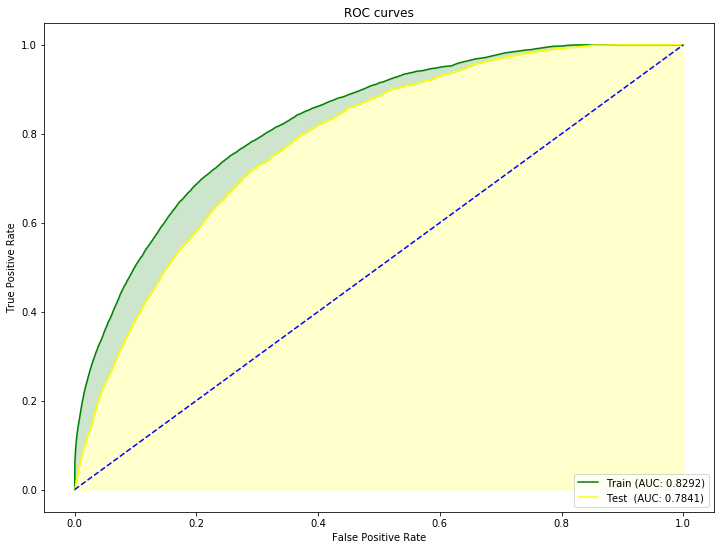

In [45]:
# ROC plotting
#plt.figure(figsize=(12,9))
#
# ROC curves:
#plt.plot(df_roc_train["fpr"], df_roc_train["tpr"], "g", label="Train (AUC: %.4f)" % auc_train)
#plt.plot(df_roc_test["fpr"], df_roc_test["tpr"], "yellow", label="Test  (AUC: %.4f)" % auc_test)
#
# Random guess:
#plt.plot([0,1],[0,1], "b--")
#
# Colour
#plt.fill_between(x=df_roc_train["fpr"], 
#                 y1=df_roc_train["tpr"], 
#                 y2=np.interp(df_roc_train["fpr"],
#                              df_roc_test["fpr"],
#                              df_roc_test["tpr"]), alpha=0.2, color="green")
#plt.fill_between(x=df_roc_test["fpr"], y1=df_roc_test["tpr"], alpha=0.2, color="yellow")
#
#plt.xlabel("False Positive Rate")
#plt.ylabel("True Positive Rate")
#plt.title("ROC curves")
#plt.legend(loc=4, fontsize=10)
#pass